# Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Make a new folder in Projects (for your specific purposes)

- Copy this ipynb file that folder

- The data is stored on L-Drive

- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    

In [1]:
# import all the needed stuff:

import time
import sys
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import easygui  # popup windows with buttons made easy
import mne  # EEGLAB for python
from IPython.display import clear_output  # to clear the cell output during while loop
import re  # regular expressions
import pickle  # to save/load data
import dynarray  # a growing numpy array

import logging
logging.basicConfig(level=logging.ERROR)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra
from nftools.analysis import convert_eeg_marker_meta_to_mne


sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

import scipy
from scipy import signal

from collections import deque  # a FILO list useful for plotting!

In [2]:
# properties of the recording, and some properties of the While Loop:
fs = 5000
nbchan = 64
updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data

In [3]:
# preparation to plot stuff in real time:
%matplotlib qt5 
plt.ion()  # enable widget plots & interactive plots

time_in_plot=2.0  # how much time in x-axis
sy1=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list
sy2=deque(np.zeros(round(fs * time_in_plot)), round(fs * time_in_plot))  # for plotting - the FILO list

channel_to_plot=10
sx = np.linspace(0, time_in_plot, round(fs * time_in_plot))


In [4]:
# real-time data filtering -- high-pass filter (of 1.0 Hz)

f_low = 1.0
# f_high = 15.0
butter_ord = 3
lenchannels = nbchan

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_hp, rt_a_hp = signal.butter(butter_ord, 2*f_low/fs, btype='high', analog=False)  # a digital high-pass filter
rt_zi_hp = proc.lfilter_zi(rt_b_hp, rt_a_hp, lenchannels)


In [5]:
# real-time data filtering -- band-pass filter (of 12.0 - 15.0 Hz)

f_low = 12.0
f_high = 15.0
butter_ord = 3
lenchannels = nbchan

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_bp, rt_a_bp = signal.butter(butter_ord, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter
rt_zi_bp = proc.lfilter_zi(rt_b_bp, rt_a_bp, lenchannels)

In [6]:
amp = libmushu.get_amp('lslamp')
amp.configure(amp='BVA')

{'amp': 'BVA'}
('name', 'BrainVision RDA')
('name', 'BrainVision RDA Markers')


In [7]:
amp.start()

In [8]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # the growing numpy data matrix
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

rb = RingBuffer(buffSize * 1000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = 100.0

fig=plt.figure()  # plotting...
th=fig.suptitle('')
ah1=fig.add_subplot(121)
ah2=fig.add_subplot(122)
l1, = ah1.plot(sx, sy1)
l2, = ah2.plot(sx, sy2)


# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
markTime=time.time()
st=''
while curTime - t0 < 15:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker = amp.get_data()
    
    
    if data.shape[0] > 0:  # this is crucial for remembering filter state.


        #data2=lpf.handle(data)
        # data3=hpf.handle(data)
        # data4= mr.handle(data)
        
        # something like this:
        #filterchain = [HPFilter, MRFilter,s LPFilter, ResampleFilter, HPFilter, CWLFilter]
        
        #corr_data = ProcessFilters(chain, (data, marker))
        
        
        # use case -- first using the MR Corrector
        #mr_data = MRFilter.filter(data)

        # then -- using the CWL corrector
        #cwl_mr_data = CWLFilter.filter(data)

        
        #dataf, rt_zi_bp = signal.lfilter(rt_b_bp, rt_a_bp, data, axis=0, zi=rt_zi_bp)  # how to operate directly on the data

        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
        f_cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)

        # f_cnt, rt_zi_bp = proc.lfilter(cnt, rt_b_bp, rt_a_bp, zi=rt_zi_bp)  # real-time data preprocessing...

        # plotting...
        sy1.extend(cnt.data[:,channel_to_plot])  # to visualize/plot -- s1 and s2 are deque's
        sy2.extend(f_cnt.data[:,channel_to_plot])
        
        l1.set_ydata(sy1)
        l2.set_ydata(sy2)
        msy1=np.mean(sy1)
        msy2=np.mean(sy2)
        ah1.set_ylim(-1000+msy1, 1000+msy1)
        ah2.set_ylim(-1000+msy2, 1000+msy2)

        fig.canvas.draw()
        fig.canvas.flush_events()
        
        # currently has no purpose
        newsamples = cnt.data.shape[0]

        # append to ringbuffer, so we can calculate features later on on the last N secs/samples of data.
        rb.append(f_cnt)

        # append it to the big matrix, for saving later on with pickle.
        alld.extend(data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += newsamples / float(sfreq) * 1000.
        


        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:
            # do Stuff

            markTime = curTime
            # 1) obtain last 1-second(s)
            d = rb.get()

            

            # clear_output(wait=True)  # write some logging information here
            # clear_output clear the output of the cell, but if you do that you also remove the figures, it seems
            # so don't do it!
            str1 = 'Playing Back - time = %f' % (curTime - t0)
            str2 = 'Length Markers: %d' % len(allm)
            str3 = '%d, %d' % data.shape
            #str4 = 'Feature Value: %f' % feature
            #str5 = 'Scaled Signal for NF: %f' % signalToSend
            #print(str1 + '\n' + str2 + '\n' + str3 + '\n' + str4 + '\n' + str5)
            
            # print('Length Markers: %d' % len(allm))
            # print(data.shape)
            th.set_text(str1 + '\n' + str2 + '\n' +str3)
            #featureth.set_text(str4 + '\n' + str5)





marker too fast! 78415.707431, 78415.816861, 78415.804603
marker too slow! 78415.816892, 78415.816861, 78415.951709
resued otherwise lost marker
marker too slow! 78419.828695, 78419.828670, 78419.849770
resued otherwise lost marker


In [9]:
amp.get_sampling_frequency()

5000.0

In [10]:
amp.stop()

amplifier stopped!


In [11]:
amp.get_channels()

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Oz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'TP9',
 'TP10',
 'POz',
 'ECG',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'FT9',
 'FT10',
 'Fpz',
 'CPz']

In [11]:
raw=convert_eeg_marker_meta_to_mne('t1')

{'Channels': ['Ch 0', 'Ch 1', 'Ch 2', 'Ch 3', 'Ch 4', 'Ch 5', 'Ch 6', 'Ch 7', 'Ch 8', 'Ch 9', 'Ch 10', 'Ch 11', 'Ch 12', 'Ch 13', 'Ch 14', 'Ch 15', 'Ch 16', 'Ch 17', 'Ch 18', 'Ch 19', 'Ch 20', 'Ch 21', 'Ch 22', 'Ch 23', 'Ch 24', 'Ch 25', 'Ch 26', 'Ch 27', 'Ch 28', 'Ch 29', 'Ch 30', 'Ch 31', 'Ch 32', 'Ch 33', 'Ch 34', 'Ch 35', 'Ch 36', 'Ch 37', 'Ch 38', 'Ch 39', 'Ch 40', 'Ch 41', 'Ch 42', 'Ch 43', 'Ch 44', 'Ch 45', 'Ch 46', 'Ch 47', 'Ch 48', 'Ch 49', 'Ch 50', 'Ch 51', 'Ch 52', 'Ch 53', 'Ch 54', 'Ch 55', 'Ch 56', 'Ch 57', 'Ch 58', 'Ch 59', 'Ch 60', 'Ch 61', 'Ch 62', 'Ch 63'], 'Sampling Frequency': 5000.0, 'Amp': '<libmushu.driver.labstreaminglayer.LSLAmp object at 0x7fd28d5b72b0>'}
Creating RawArray with float64 data, n_channels=64, n_times=501700
    Range : 0 ... 501699 =      0.000 ...   100.340 secs
Ready.
<RawArray  |  None, n_channels x n_times : 64 x 501700 (100.3 sec), ~245.1 MB, data loaded>
["1242.699514 ['Sync Off']", "3220.000000 ['Sync Off']", "5182.519897 ['Sync Off']", "72

In [12]:
evs=mne.find_events(raw)

NameError: name 'raw' is not defined

In [13]:
plt.figure()

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(np.diff(evs[:,0]))

In [24]:
plt.show()

In [13]:
raw.save('100sec.fif', overwrite=True)

This filename (100sec.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Overwriting existing file.
Writing /home/nfcontrol/nf/nf-rtime/Projects_Templates/3_RTMRICWL/100sec.fif


<ipython-input-13-407253abe619>:1: RuntimeWarning: This filename (100sec.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw.save('100sec.fif', overwrite=True)


Closing /home/nfcontrol/nf/nf-rtime/Projects_Templates/3_RTMRICWL/100sec.fif [done]


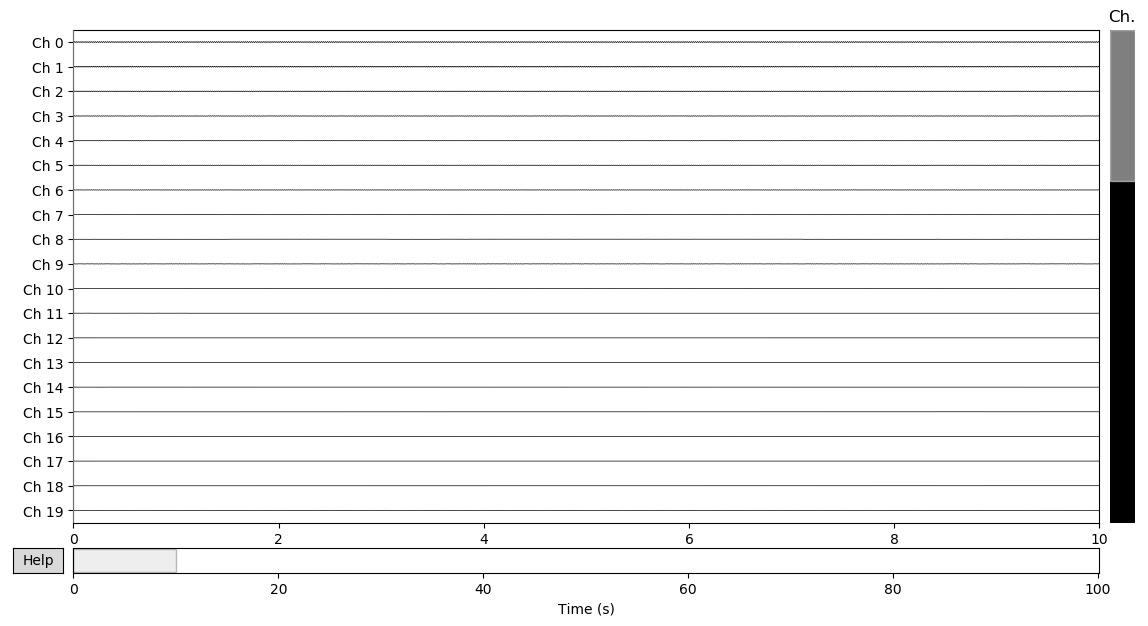

In [14]:
raw.plot(scalings='auto')

In [13]:
amp.stop()
alld.shrink_to_fit()

amplifier stopped!


In [12]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [2]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [13]:
allm

[[122.05318300402723, 'Sync Off'],
 [2120.0309545139316, 'Sync Off'],
 [4120.03139898763, 'Sync Off'],
 [6122.240727499593, 'Sync Off'],
 [8120.0, 'Sync Off'],
 [10063.797904482577, 'Sync Off'],
 [12120.0, 'Sync Off'],
 [14101.304729492404, 'Sync Off']]

In [14]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
# raw.resample(1000)

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:111: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=76100
    Range : 0 ... 76099 =      0.000 ...    15.220 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=76100
    Range : 0 ... 76099 =      0.000 ...    15.220 secs
Ready.
> /home/nfcontrol/nf/nf-rtime/nftools/nftools/analysis.py(148)convert_alld_allm_to_mne()
    147     # create the marker matrix:
--> 148     if len(allm)>0:
    149         raw.add_events(ev_arr)



ipdb>  allm


[[122.05318300402723, 'Sync Off'], [2120.0309545139316, 'Sync Off'], [4120.03139898763, 'Sync Off'], [6122.240727499593, 'Sync Off'], [8120.0, 'Sync Off'], [10063.797904482577, 'Sync Off'], [12120.0, 'Sync Off'], [14101.304729492404, 'Sync Off']]


ipdb>  c


In [16]:
%matplotlib qt5

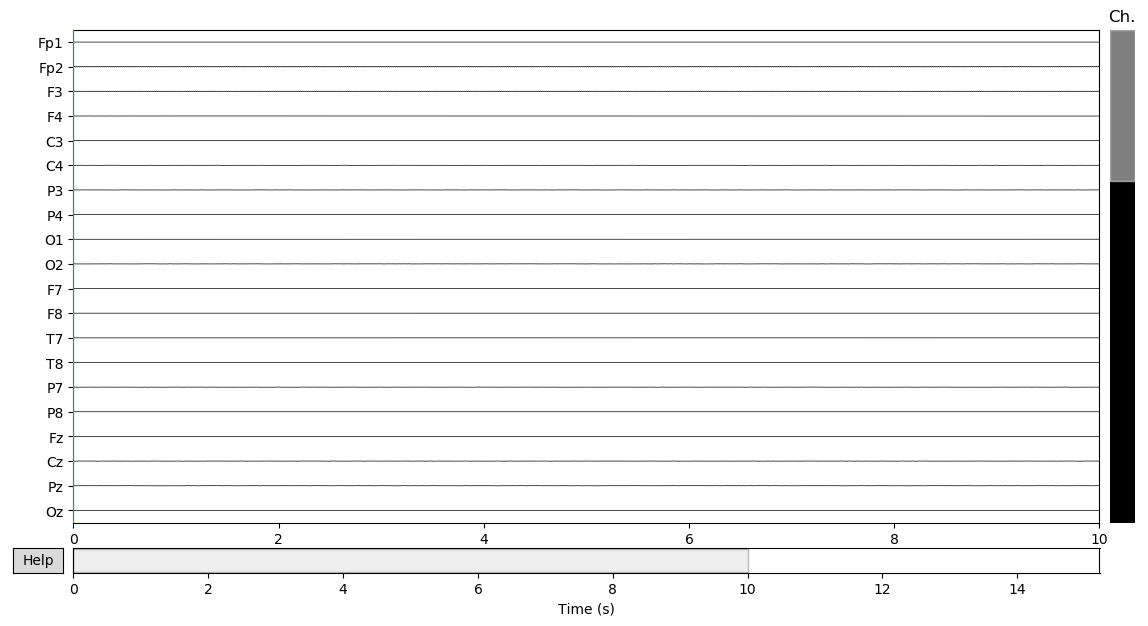

In [19]:
raw.plot(scalings='auto')

In [13]:
import ipdb

In [15]:
ipdb.post_mortem(sys.last_traceback)

> /home/nfcontrol/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/numeric.py(501)asarray()
    500     """
--> 501     return array(a, dtype, copy=False, order=order)
    502 



ipdb>  u


> /home/nfcontrol/.conda/envs/rt/lib/python3.6/site-packages/mne/io/base.py(2088)add_events()
   2087             raise RuntimeError('cannot add events unless data are preloaded')
-> 2088         events = np.asarray(events)
   2089         if events.ndim != 2 or events.shape[1] != 3:



ipdb>  u


> /home/nfcontrol/nf/nf-rtime/nftools/nftools/analysis.py(144)convert_alld_allm_to_mne()
    143     if len(allm)>0:
--> 144         raw.add_events(ev_arr)
    145 



ipdb>  raw


<RawArray  |  None, n_channels x n_times : 65 x 82520 (16.5 sec), ~41.1 MB, data loaded>


ipdb>  raw_add_events?


*** SyntaxError: invalid syntax


ipdb>  raw.add_events?


*** SyntaxError: invalid syntax


ipdb>  raw.add_events


<bound method BaseRaw.add_events of <RawArray  |  None, n_channels x n_times : 65 x 82520 (16.5 sec), ~41.1 MB, data loaded>>


ipdb>  q


In [17]:
raw.add_events

NameError: name 'raw' is not defined

In [14]:
amp.get_channels()

In [13]:
ch_names

['Ch 0',
 'Ch 1',
 'Ch 2',
 'Ch 3',
 'Ch 4',
 'Ch 5',
 'Ch 6',
 'Ch 7',
 'Ch 8',
 'Ch 9',
 'Ch 10',
 'Ch 11',
 'Ch 12',
 'Ch 13',
 'Ch 14',
 'Ch 15',
 'Ch 16',
 'Ch 17',
 'Ch 18',
 'Ch 19',
 'Ch 20',
 'Ch 21',
 'Ch 22',
 'Ch 23',
 'Ch 24',
 'Ch 25',
 'Ch 26',
 'Ch 27',
 'Ch 28',
 'Ch 29',
 'Ch 30',
 'Ch 31',
 'Ch 32',
 'Ch 33',
 'Ch 34',
 'Ch 35',
 'Ch 36',
 'Ch 37',
 'Ch 38',
 'Ch 39',
 'Ch 40',
 'Ch 41',
 'Ch 42',
 'Ch 43',
 'Ch 44',
 'Ch 45',
 'Ch 46',
 'Ch 47',
 'Ch 48',
 'Ch 49',
 'Ch 50',
 'Ch 51',
 'Ch 52',
 'Ch 53',
 'Ch 54',
 'Ch 55',
 'Ch 56',
 'Ch 57',
 'Ch 58',
 'Ch 59',
 'Ch 60',
 'Ch 61',
 'Ch 62',
 'Ch 63']

In [24]:
raw.plot(scalings='auto');

In [19]:
# raw.set_eeg_reference(ref_channels='average')
# better not (yet) - before removing bad channels, since these mess up your data big time: see PREP paper:


In [16]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')

raw.notch_filter(np.arange(50, 300, 50), picks=picks, filter_length='auto', phase='zero')
# add it (potentialy) some other preprocessing steps here

Setting up band-stop filter
Filter length of 33001 samples (6.600 sec) selected


<RawArray  |  None, n_channels x n_times : 39 x 400001 (80.0 sec), ~119.1 MB, data loaded>

In [17]:
raw.plot_psd(tmax=np.inf, fmax=1000, n_fft=2048*4);

Effective window size : 1.638 (s)


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/mne/viz/evoked.py:162: RuntimeWarning: invalid value encountered in maximum
  rgb /= np.maximum(rgb.max(0), 1e-16)  # avoid div by zero
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/johan/.conda/envs/rt/lib/python3.6/site-packag

In [14]:
mne.viz.plot_sensors(raw.info, show_names=True, ch_type='eeg');

RuntimeError: No digitization points found.

In [15]:
raw.info['chs']

[{'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2,
  'coil_type': 1,
  'unit': 107,
  'coord_frame': 0,
  'ch_name': 'Ch 0',
  'scanno': 1,
  'logno': 1},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2,
  'coil_type': 1,
  'unit': 107,
  'coord_frame': 0,
  'ch_name': 'Ch 1',
  'scanno': 2,
  'logno': 2},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2,
  'coil_type': 1,
  'unit': 107,
  'coord_frame': 0,
  'ch_name': 'Ch 2',
  'scanno': 3,
  'logno': 3},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0,
  'range': 1.0,
  'cal': 1.0,
  'kind': 2,
  'coil_type': 1,
  'unit': 107,
  'coord_frame': 0,
  'ch_name': 'Ch 3',
  'scanno': 4,
  'logno': 4},
 {'loc': array([nan, nan, nan, n

In [28]:
mne.viz.plot_sensors?

Signature: mne.viz.plot_sensors(info, kind='topomap', ch_type=None, title=None, show_names=False, ch_groups=None, to_sphere=True, axes=None, block=False, show=True)
Docstring:
Plot sensors positions.

Parameters
----------
info : Instance of Info
    Info structure containing the channel locations.
kind : str
    Whether to plot the sensors as 3d, topomap or as an interactive
    sensor selection dialog. Available options 'topomap', '3d', 'select'.
    If 'select', a set of channels can be selected interactively by using
    lasso selector or clicking while holding control key. The selected
    channels are returned along with the figure instance. Defaults to
    'topomap'.
ch_type : None | str
    The channel type to plot. Available options 'mag', 'grad', 'eeg',
    'seeg', 'ecog', 'all'. If ``'all'``, all the available mag, grad, eeg,
    seeg and ecog channels are plotted. If None (default), then channels
    are chosen in the order given above.
title : str | None
    Title for the 